# Dataset

In [ ]:
!pip install -U sentence-transformers
!pip install annoy

In [ ]:
#Set up
import pandas as pd
from sentence_transformers import SentenceTransformer
import numpy as np
from sklearn.manifold import TSNE
import seaborn as sns
from google.colab import drive
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import accuracy_score
from sklearn.cluster import DBSCAN
from annoy import AnnoyIndex
from difflib import SequenceMatcher

drive.mount('/content/drive')


Mounted at /content/drive


### Parameters

In [ ]:
SAMPLES = 576
NEIGHBORS = 5
TREES = 10
MIN_SAMPLES = 5
EPS = 0.5

### Load data

In [ ]:
df = pd.read_csv('/content/drive/My Drive/USP/TCC/data.csv', encoding="latin", delimiter=',', engine='c')
df

,Numero,Data_de_emissao,Situacao,Valor_total_da_nota,Nota_referenciada,Nome_razao_social_emit,CPF_CNPJ_emit,Endereco_emit,Bairro_distrito_emit,CEP_emit,...,Aliq_ICMS_ST_prod,Valor_IPI_prod,Aliq_IPI_prod,Valor_PMC_prod,Cod_EAN,Info_Adicional_Item,Informacoes_adicionais_do_FISCO,Informacoes_complementares,Unid_prod,Metrica
0,8326,2016-02-04 14:30:38,A,45.99,NaN,LEIA COMERCIAL DE LIVROS E MAGAZINE LTDA,11895653000100,AV. PRESIDENTE JOAO PESSOA,CENTRO,58900000.0,...,NaN,0.0,0.0,NaN,7.897833e+12,NaN,NaN,Referente o Cupom :(050213) Do ECF: (0002),UND,0.024026
1,8326,2016-02-04 14:30:38,A,45.99,NaN,LEIA COMERCIAL DE LIVROS E MAGAZINE LTDA,11895653000100,AV. PRESIDENTE JOAO PESSOA,CENTRO,58900000.0,...,NaN,0.0,0.0,NaN,7.898538e+12,NaN,NaN,Referente o Cupom :(050213) Do ECF: (0002),UND,0.117621
2,8326,2016-02-04 14:30:38,A,45.99,NaN,LEIA COMERCIAL DE LIVROS E MAGAZINE LTDA,11895653000100,AV. PRESIDENTE JOAO PESSOA,CENTRO,58900000.0,...,NaN,0.0,0.0,NaN,7.898538e+12,NaN,NaN,Referente o Cupom :(050213) Do ECF: (0002),UND,0.119840
3,8326,2016-02-04 14:30:38,A,45.99,NaN,LEIA COMERCIAL DE LIVROS E MAGAZINE LTDA,11895653000100,AV. PRESIDENTE JOAO PESSOA,CENTRO,58900000.0,...,NaN,0.0,0.0,NaN,3.154147e+12,NaN,NaN,Referente o Cupom :(050213) Do ECF: (0002),UND,0.101036
4,8326,2016-02-04 14:30:38,A,45.99,NaN,LEIA COMERCIAL DE LIVROS E MAGAZINE LTDA,11895653000100,AV. PRESIDENTE JOAO PESSOA,CENTRO,58900000.0,...,NaN,0.0,0.0,NaN,7.897477e+12,NaN,NaN,Referente o Cupom :(050213) Do ECF: (0002),UND,0.209856
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2089312,2719,2016-04-25 18:54:15,A,665.11,NaN,SANTA BARBARA SUPERMERCADO,16576198000196,AV. COMANDANTE VITAL ROLIM,CENTRO,58900000.0,...,NaN,0.0,0.0,NaN,7.898288e+12,NaN,NaN,Referente (28) a (Coo-ECF): (89045-5)(106342-4...,UND,0.286238
2089313,2719,2016-04-25 18:54:15,A,665.11,NaN,SANTA BARBARA SUPERMERCADO,16576198000196,AV. COMANDANTE VITAL ROLIM,CENTRO,58900000.0,...,NaN,0.0,0.0,NaN,7.898288e+12,NaN,NaN,Referente (28) a (Coo-ECF): (89045-5)(106342-4...,Pacote,0.277469
2089314,2719,2016-04-25 18:54:15,A,665.11,NaN,SANTA BARBARA SUPERMERCADO,16576198000196,AV. COMANDANTE VITAL ROLIM,CENTRO,58900000.0,...,NaN,0.0,0.0,NaN,7.898406e+12,NaN,NaN,Referente (28) a (Coo-ECF): (89045-5)(106342-4...,UND,0.000331
2089315,2719,2016-04-25 18:54:15,A,665.11,NaN,SANTA BARBARA SUPERMERCADO,16576198000196,AV. COMANDANTE VITAL ROLIM,CENTRO,58900000.0,...,NaN,0.0,0.0,NaN,7.896049e+12,NaN,NaN,Referente (28) a (Coo-ECF): (89045-5)(106342-4...,UND,0.460539


In [ ]:
df_filtered = df[['Descricao_do_Produto_ou_servicos', 'NCM_prod', 'Valor_unit_prod']]
df_filtered

,Descricao_do_Produto_ou_servicos,NCM_prod,Valor_unit_prod
0,GRAMPO PLAST DELLO FIX BC - 0301.E0020.2 - DELO,39261000.0,9.95
1,LAPISEIRA TECNICA NPY 0.9 - 14088 - MOLIN,96084000.0,8.30
2,LAPISEIRA TEC JOB 0.7 - 14077 - MOLIN,96084000.0,6.95
3,MARCA TEXTO FLUO PEPS AMARELO - 742534 - MAPED,96082000.0,3.70
4,GRAMPEADOR 26/6 T320 12CM 20F PRETO - 665207 ...,84729040.0,16.50
...,...,...,...
2089312,COPO DESCARTAVEL MARATA 150ML,39241000.0,2.65
2089313,COPO DESC MARATA 50ML 100UN,39241000.0,1.45
2089314,AMANTEIGADOS BEM ME QUER 300G,19053100.0,5.49
2089315,SACO P/LIXO DYPLAST 15 LITROS,39232190.0,1.98


In [ ]:
df_filtered = df_filtered.loc[df_filtered['NCM_prod'] == 19053100.0]

description_list = df_filtered['Descricao_do_Produto_ou_servicos'].str.split()
description = [i[0] for i in description_list]
df_filtered.insert(loc=3,column='description', value=description)

df_filtered.insert(loc=4, column='label', value=df_filtered['description'].astype('category').cat.codes)
df_filtered

,Descricao_do_Produto_ou_servicos,NCM_prod,Valor_unit_prod,description,label
16,SALGADOS,19053100.0,33.00,SALGADOS,265
72,BISC.FORT.MAIZENA 400G,19053100.0,3.75,BISC.FORT.MAIZENA,50
255,BISC 3 DE MAIO SALGADO 400GR,19053100.0,2.79,BISC,27
259,BISC BEIJA FLOR DOCE 400GR,19053100.0,2.49,BISC,27
260,BISC BEIJA FLOR SAL 400GR,19053100.0,2.49,BISC,27
...,...,...,...,...,...
2087743,BISCOITO CREAM CRACKER - VITAMASSA,19053100.0,1.97,BISCOITO,91
2089073,BISC.VITAMASSA 400G CREAM CRACKER,19053100.0,2.69,BISC.VITAMASSA,83
2089301,BISCOITO MAIZENA TRADICIONAL VITARELLA 400G,19053100.0,2.49,BISCOITO,91
2089302,BISCOITO BEM ME QUER 150G,19053100.0,3.99,BISCOITO,91


In [ ]:
df_filtered = df_filtered.sample(frac=1).reset_index(drop=True)
df_filtered

,Descricao_do_Produto_ou_servicos,NCM_prod,Valor_unit_prod,description,label
0,BISCOITO SALGADO,19053100.0,2.40,BISCOITO,91
1,BISC. MAIZENA VITARELLA TRADICIONAL 400G,19053100.0,2.65,BISC.,30
2,BISC. CREAM CRACKER INT. 400 G,19053100.0,3.00,BISC.,30
3,BISC. MARIA VITARELLA 400G,19053100.0,2.35,BISC.,30
4,BISCOITO TRES DE MAIO MARIA 400G,19053100.0,2.15,BISCOITO,91
...,...,...,...,...,...
18527,BISCOITO TRES DE MAIO MARIA 400G,19053100.0,2.15,BISCOITO,91
18528,BBIS CRE CRACKER CAPRICCHE MAMMAMIA INTEG 400G,19053100.0,3.49,BBIS,16
18529,SORDA PRETA C/ 20,19053100.0,3.35,SORDA,274
18530,BISCOITO CREAM CRACKER EMBAL. 20X400G,19053100.0,54.05,BISCOITO,91


In [ ]:
model = SentenceTransformer('neuralmind/bert-large-portuguese-cased')
embeddings = model.encode(df_filtered.Descricao_do_Produto_ou_servicos.to_list())

Downloading:   0%|          | 0.00/391 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.62k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/648 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/155 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/210k [00:00<?, ?B/s]

Some weights of the model checkpoint at /root/.cache/torch/sentence_transformers/neuralmind_bert-large-portuguese-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
df_filtered['embeddings'] = list(embeddings)
df_filtered

In [ ]:
X = np.array(df_filtered.sample(SAMPLES).embeddings.to_list())
print(X.shape) 

In [ ]:
X_tsne = TSNE(n_components=2,init='random').fit_transform(X) # apenas para visualizacao


In [ ]:
df_filtered_tsne = pd.DataFrame(X_tsne)
sns.scatterplot(data=df_filtered_tsne, x=0, y=1)

# Mutual Nearest Neighbours

Um dos objetivos do projeto é avaliar versão "MNN" de métodos que usam proximidade, como clustering (kmeans, dbscan, etc) e classificação (e.g. knn). No entanto, conforme será discutido, MNN é computacionalmente caro.

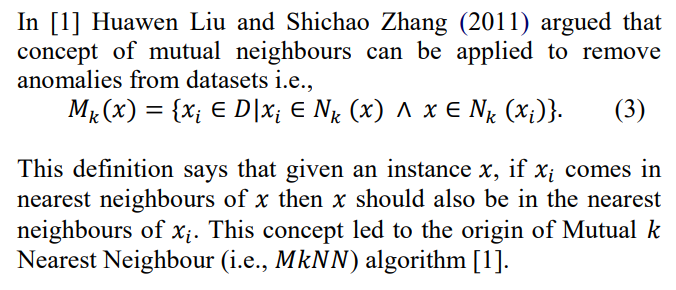

# MNN - DBScan (Baseline)

In [ ]:
neigh = NearestNeighbors(n_neighbors=NEIGHBORS,metric='cosine',algorithm="brute")
neigh.fit(X)

In [ ]:
def my_dissimilarity(x,y):
  L1 = list(neigh.kneighbors([x])[1][0])
  L2 = list(neigh.kneighbors([y])[1][0])
  return 1.0 - len(set(L1).intersection(L2)) / len(set(L1+L2))

clustering = DBSCAN(eps=EPS, min_samples=MIN_SAMPLES, metric=my_dissimilarity, algorithm='brute').fit(X)

df_filtered_tsne = pd.DataFrame(X_tsne)
df_filtered_tsne['cluster_label'] = clustering.labels_
sns.scatterplot(data=df_filtered_tsne, x=0, y=1, hue="cluster_label")

# MNN - DBScan + ANN

### MNN apresenta muitas vantagens, mas é computacionalmente caro. Podemos acelerar o cálculo dos vizinhos com ANN. Aproveitar propriedades de que tais métodos erram pouco nos top-k vizinhos, com k pequeno.

In [ ]:
f = X.shape[1]  # Length of item vector that will be indexed

t = AnnoyIndex(f, 'angular')
for i in range(0,len(X)):
    t.add_item(i, X[i])

TREES=10
t.build(TREES) # Number of trees
# t.save('test.ann')
# t = AnnoyIndex(f, 'angular')
# t.load('test.ann') # super fast, will just mmap the file

In [ ]:
def my_dissimilarity_ann(x,y):
  L1 = t.get_nns_by_vector(x,n=NEIGHBORS, search_k = (TREES*(NEIGHBORS)*1))
  L2 = t.get_nns_by_vector(y,n=NEIGHBORS, search_k = (TREES*(NEIGHBORS)*1))
  return 1.0 - len(set(L1).intersection(L2)) / len(set(L1+L2))


clustering_ann = DBSCAN(eps=EPS, min_samples=MIN_SAMPLES, metric=my_dissimilarity_ann, algorithm='brute').fit(X)

In [ ]:
df_filtered_tsne = pd.DataFrame(X_tsne)
df_filtered_tsne['cluster_label'] = clustering_ann.labels_
sns.scatterplot(data=df_filtered_tsne, x=0, y=1, hue="cluster_label")

In [ ]:
accuracy = accuracy_score(clustering.labels_, clustering_ann.labels_)*100
print("Accuracy:"+str(accuracy)+"%")

In [ ]:
df_filtered['cluster_label'] = pd.Series(clustering_ann.labels_)
result = df_filtered[['Descricao_do_Produto_ou_servicos', 'cluster_label', 'description','NCM_prod', 'Valor_unit_prod']][:SAMPLES]
result